In [1]:
import pandas as pd
import numpy as np
import math
from io import StringIO
import fastparquet
from obfuscation import obfuscation as obf
from obfuscation import utils
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'obfuscation'

In [2]:
# # Read original MovieLens 1M data
# df_ratings = pd.read_csv("../data/ml-1m/ratings.dat", sep="::", header=None, engine="python", usecols=[0,1,2])
# df_ratings.columns = ['user_id', 'item_id', 'rating']

In [ ]:
# cols_export = set(['user_id', 'movie_id', 'rating', 'z_rating_noise', 'rating_noise'])
# is_standard = True
# sigma_max = utils.sigma_max(df_ratings, is_standard)
# sigma_max

In [2]:
# ML-1m
id_col = 'user_id'
item_col = 'movie_id'
target_col = 'rating'
interaction_cols = ['interaction']

In [2]:
# LastFm-filtered
id_col = 'user_id'
item_col = 'item_id'
target_col = 'rating'
interaction_cols = ['interaction']

In [3]:
ts = '230619'
ts = '231017'
ts = '231018'
ts = '231020'
ts = '231023'
ts = '231106'
ts = '240412'

# Random response (interactions)

## Read input

#### ML-1m

In [4]:
# Read interactions data ml-1m-interactions (prepared by Alex)
# for random response, we will cross them with the original data
ds_name = 'ml-1m-response'
df_ratings_train = pd.read_excel('../data/{}/implicit_train_df.xlsx'.format(ds_name))
# df_ratings_test = pd.read_excel('../data/ml-1m-interactions/implicit_test_df.xlsx')
df_ratings_train.shape

(830438, 3)

#### LastFM-filtered

In [4]:
# read filtered LastFM data, prepared by Alex
ds_name = 'lastfm-filtered-response'
df_ratings_train = pd.read_excel('../data/{}/train_df.xlsx'.format(ds_name), engine='openpyxl')
df_ratings_train.drop(columns=['Unnamed: 0', 'timestamp'], inplace=True)
df_ratings_train['rating'] = 1
df_ratings_train.shape

(349076, 3)

In [5]:
# # only if read from the original ML-1M data
# df_ratings['interaction'] = df_ratings['rating'] >= 3
# df_ratings['interaction'].replace({True:1, False:0}, inplace=True)

# if from Alex, just rename the column
df_ratings = df_ratings_train.copy()
df_ratings.rename(columns={'rating': 'interaction'}, inplace=True)
item_col = 'item_id'
cols_export = set([id_col, item_col, 'interaction', 'interaction_r'])

In [6]:
df_ratings.shape

(349076, 3)

## Initialise experimental parameters

In [7]:
grp_sizes = [1,2,3,5,7,10,11,13,17,19]
thetas = [.2, .4, .6, .8, 1.]

In [13]:
# cols_export = set([id_col, item_col, target_col, 'interaction', 'interaction_r'])

In [8]:
def generate_random_sets(is_masking:bool, is_fixed_response:bool, grp_sizes:list, thetas:list, cols_export:list):
    print('Generate random response: masking {}, fixed response {}'.format(is_masking, is_fixed_response))
    for n_grps in grp_sizes:
        for theta_max in thetas:
            print('n_groups={}, theta_max={}'.format(n_grps, theta_max))
            df = obf.response_no_masking(
                df_ratings, is_fixed_response=True, id_col='user_id', theta_max=theta_max, n_groups=n_grps, interaction_col_names=interaction_cols)
            df[cols_export].to_csv('../data/ml-1m-response/rand_response_no_masking_fixed{}_groups{}_theta{}.csv'.format(is_fixed_response, n_grps, theta_max), index=False)

## Experiment

In [9]:
is_masking = True
is_fixed_response = True
df_stats = pd.DataFrame(columns=['n_groups', 'theta_max', 'n_interactions', 'n_synthetic'])
for n_grps in grp_sizes:
    for theta_max in thetas:
        print('n_groups={}, theta_max={}'.format(n_grps, theta_max))
        if is_masking:
            df, df_synthetic = obf.response_with_masking(
                df_ratings, is_fixed_response=True, id_col=id_col, item_col=item_col, interaction_col_names=interaction_cols, theta_max=theta_max)
            # add the original/synthetic flag
            df['is_original'] = True
            df_synthetic['is_original'] = False
            cols_export.add('is_original')
            if 'rating' in cols_export:
                cols_export.remove('rating')

            # concatenate the original and synthetic data with noise
            df = pd.concat([df[list(cols_export)], df_synthetic[list(cols_export)]])
            
            df_stats = pd.concat(
                [df_stats, pd.DataFrame([[n_grps, theta_max, sum(df['interaction_r']), df.shape[0]]], columns=df_stats.columns)], ignore_index=True)
        else:
            df = obf.response_no_masking(
                df_ratings, is_fixed_response=is_fixed_response, id_col=id_col, theta_max=theta_max, n_groups=n_grps, interaction_col_names=interaction_cols)
            df_stats = pd.concat(
                [df_stats, pd.DataFrame([[n_grps, theta_max, sum(df['interaction_r']), df.shape[0]]], columns=df_stats.columns)], ignore_index=True)
        df[list(cols_export)].to_parquet(
            '../data/{}/{}/rand_response_masking{}_fixed{}_groups{}_theta{}_train.parq'.format(ds_name, ts, is_masking, is_fixed_response, n_grps, theta_max), 
            index=False, engine='fastparquet')
df_stats.to_csv('../data/{}/{}/stats/rand_response_masking{}_fixed{}_train.csv'.format(ds_name, ts, is_masking, is_fixed_response), index=False)

n_groups=1, theta_max=0.2
n_groups=1, theta_max=0.4
n_groups=1, theta_max=0.6
n_groups=1, theta_max=0.8
n_groups=1, theta_max=1.0
n_groups=2, theta_max=0.2
n_groups=2, theta_max=0.4
n_groups=2, theta_max=0.6
n_groups=2, theta_max=0.8
n_groups=2, theta_max=1.0
n_groups=3, theta_max=0.2
n_groups=3, theta_max=0.4
n_groups=3, theta_max=0.6
n_groups=3, theta_max=0.8
n_groups=3, theta_max=1.0
n_groups=5, theta_max=0.2
n_groups=5, theta_max=0.4
n_groups=5, theta_max=0.6
n_groups=5, theta_max=0.8
n_groups=5, theta_max=1.0
n_groups=7, theta_max=0.2
n_groups=7, theta_max=0.4
n_groups=7, theta_max=0.6
n_groups=7, theta_max=0.8
n_groups=7, theta_max=1.0
n_groups=10, theta_max=0.2
n_groups=10, theta_max=0.4
n_groups=10, theta_max=0.6
n_groups=10, theta_max=0.8
n_groups=10, theta_max=1.0
n_groups=11, theta_max=0.2
n_groups=11, theta_max=0.4
n_groups=11, theta_max=0.6
n_groups=11, theta_max=0.8
n_groups=11, theta_max=1.0
n_groups=13, theta_max=0.2
n_groups=13, theta_max=0.4
n_groups=13, theta_max=0.6

### Tests with 1 instantiation of the loop above

In [22]:
theta_max = 1.
n_grps = 7
df = obf.response_no_masking(
                df_ratings, is_fixed_response=is_fixed_response, id_col=id_col, theta_max=theta_max, n_groups=n_grps, interaction_col_names=interaction_cols)

In [37]:
df.groupby('user_id').count()['item_id'].sort_values()

user_id
4349       6
1102       8
4056       8
4365       8
4636       8
        ... 
1015    1144
3618    1145
1680    1514
4277    1714
4169    1967
Name: item_id, Length: 6038, dtype: int64

In [41]:
sum(df['interaction']), sum(df['interaction_r'])

(830438, 413824)

In [ ]:
df, df_synthetic = obf.response_with_masking(df_ratings, is_fixed_response=is_fixed_response, id_col=id_col, item_col=item_col, interaction_col_names=interaction_cols)

In [11]:
df_synthetic.groupby(['user_id']).size()

user_id
1        15
2        37
3        15
4         6
5        58
       ... 
6036    261
6037     59
6038      5
6039     36
6040    100
Length: 6040, dtype: int64

In [13]:
# add the original/synthetic flag
df['is_original'] = True
df_synthetic['is_original'] = False
cols_export.append('is_original')
if 'rating' in cols_export:
    cols_export.remove('rating')

# concatenate the original and synthetic data with noise
df_agg = pd.concat([df[cols_export], df_synthetic[cols_export]])

In [14]:
df_agg.to_parquet('test', index=False, engine='fastparquet')

# Randomised Perturbation (explicit feedback)

In [7]:
# prerequisites for train data processing - dataset from Alex
item_col = 'item_id'
# df_ratings_train = df_ratings_train[[id_col, item_col]].merge(df_ratings, on=[id_col, item_col], how='left')
df_ratings_train = pd.read_csv('../data/ml-1m-obfuscation/train_df.csv')
cols_export = set([id_col, item_col, target_col, target_col+'_noise', 'z_'+target_col+'_noise'])

In [8]:
df_ratings = df_ratings_train.copy()

In [7]:
df_ratings = utils.transform_standardize(df_ratings, id_col=id_col, target_col=target_col)
df_ratings = utils.transform_compute_desc_stats(df_ratings, id_col=id_col, target_col=target_col)

In [7]:
# df = obf.perturbation_no_masking(df, is_fixed=is_fixed_response, id_col=id_col, target_col=target_col, sigma_max=sigma_max)

In [ ]:
# df1, df2 = obf.perturbation_with_masking(df, is_fixed=is_fixed_response, id_col=id_col, target_col=target_col, item_col=item_col, sigma_max=sigma_max)

In [8]:
sigmas = [.2, .4, .6, .8, 1.]

In [9]:
cols_export

{'item_id', 'rating', 'rating_noise', 'user_id', 'z_rating_noise'}

In [15]:
is_masking = True
is_fixed_response = False
for sigma_max in sigmas:
    print('sigma_max={}'.format(sigma_max))
    if is_masking:
        df, df_synthetic = obf.perturbation_with_masking(
            df_ratings, is_fixed=is_fixed_response, 
            id_col=id_col, item_col=item_col, target_col=target_col, sigma_max=sigma_max)
        cols_export.add('is_original')
        # concatenate the original and synthetic data with noise
        df = pd.concat([df[list(cols_export)], df_synthetic[list(cols_export)]])
    else:
        df = obf.perturbation_no_masking(
            df_ratings, is_fixed=is_fixed_response, id_col=id_col, target_col=target_col, sigma_max=sigma_max)
    df[list(cols_export)].to_parquet(
        '../data/{}-ml-1m-train-obfuscation/rand_perturbation_masking{}_fixed{}_sigma{}_train.parq'.format(
            ts, is_masking, is_fixed_response, sigma_max), 
        index=False, engine='fastparquet')

sigma_max=0.2
sigma_max=0.4
sigma_max=0.6
sigma_max=0.8
sigma_max=1.0


In [11]:
df

,z_rating_noise,user_id,is_original,item_id,rating_noise,rating
0,-1.675385,1,True,661,3.026875,3
1,-2.061252,1,True,914,2.766622,3
2,0.359790,1,True,3408,4.399528,4
3,1.478494,1,True,2355,5.154054,5
4,-0.476784,1,True,1197,3.835289,3
...,...,...,...,...,...,...
220969,-0.789651,6037,False,1483,3.262660,1
220970,-1.121879,6037,False,3401,3.015103,1
220971,NaN,6038,False,NaN,NaN,5
220972,NaN,6039,False,NaN,NaN,3


<AxesSubplot: >

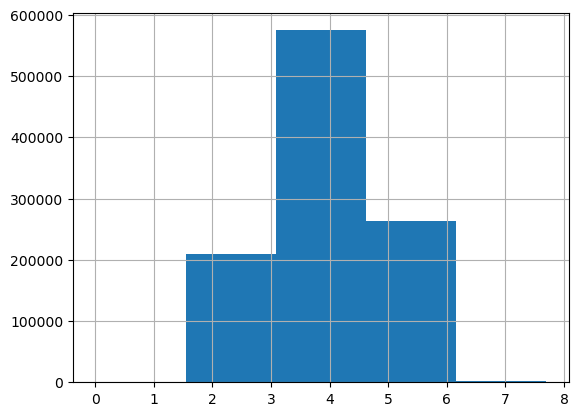

In [15]:
df['rating_noise'].hist(bins=5)

<AxesSubplot: >

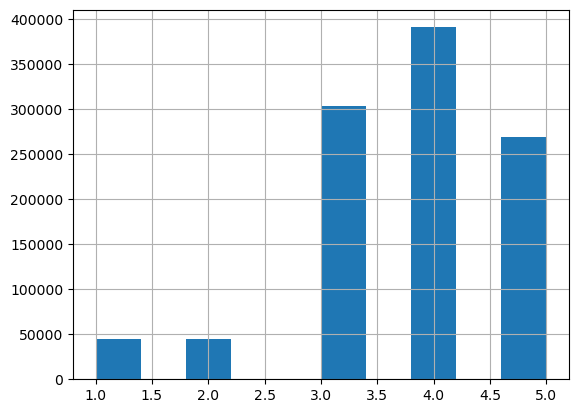

In [14]:
df['rating'].hist()

# Analysis of the generated sample sizes

We want to look how many interactions are generated for each of the frameworks, as this may end up influencing the performance of the recommender.

## Random response (implicit feedback)

In [12]:
ts = '231023'

#### Mask, fixed

In [13]:
is_masking = True
is_fixed_response = True

In [14]:
df_stats = pd.read_csv('../data/ml-1m-response/{}/stats/rand_response_masking{}_fixed{}_train.csv'.format(ts, is_masking, is_fixed_response))

/var/folders/6z/lrdd38_n45q0wxx6fhjkfsk8vyg1nm/T/ipykernel_78179/2145999909.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_stats.pivot('theta_max', 'n_groups', 'n_interactions').plot(marker='o')


<AxesSubplot: xlabel='theta_max'>

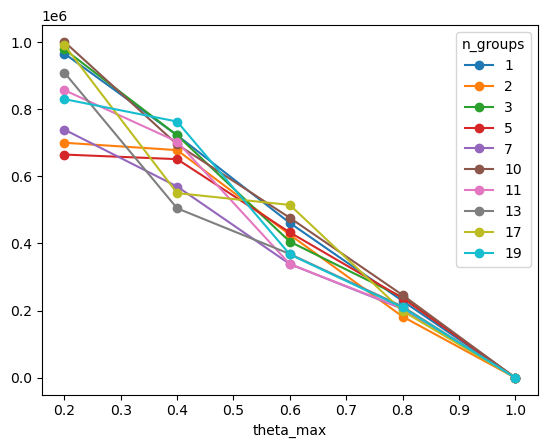

In [15]:
df_stats.pivot('theta_max', 'n_groups', 'n_interactions').plot(marker='o')

/var/folders/6z/lrdd38_n45q0wxx6fhjkfsk8vyg1nm/T/ipykernel_78179/32879989.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ax.plot(df_stats.pivot('n_groups', 'theta_max', 'n_interactions'), marker='o')
/var/folders/6z/lrdd38_n45q0wxx6fhjkfsk8vyg1nm/T/ipykernel_78179/32879989.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.sort(df_stats['n_groups'].unique()))


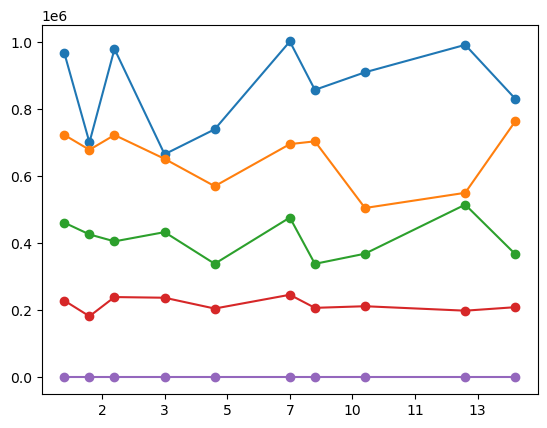

In [16]:
fig, ax = plt.subplots()
ax.plot(df_stats.pivot('n_groups', 'theta_max', 'n_interactions'), marker='o')
ax.set_xticklabels(np.sort(df_stats['n_groups'].unique()))
plt.show()

<AxesSubplot: xlabel='theta_max', ylabel='n_interactions'>

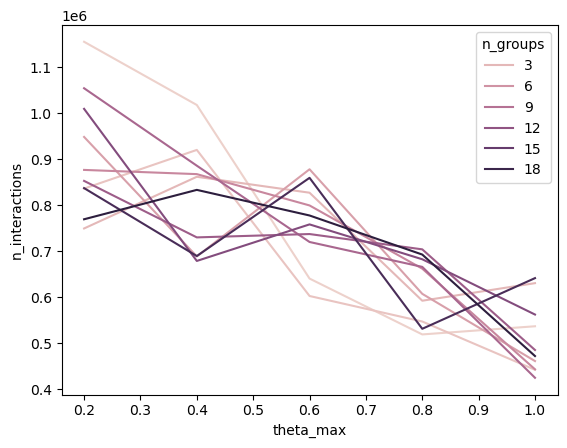

In [78]:
sns.lineplot(x='theta_max', y='n_interactions', hue='n_groups', data=df_stats)

#### Mask, variable

In [12]:
is_masking = True
is_fixed_response = False

In [13]:
df_stats = pd.read_csv('../data/ml-1m-response/{}/stats/rand_response_masking{}_fixed{}_train.csv'.format(ts, is_masking, is_fixed_response))

/var/folders/6z/lrdd38_n45q0wxx6fhjkfsk8vyg1nm/T/ipykernel_50171/493591887.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_stats.pivot('theta_max', 'n_groups', 'n_interactions').plot()


<AxesSubplot: xlabel='theta_max'>

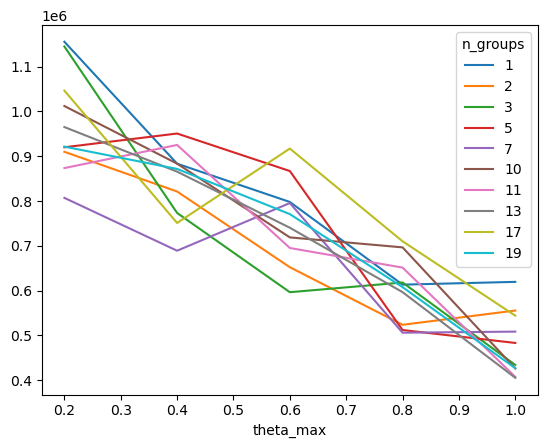

In [45]:
df_stats.pivot('theta_max', 'n_groups', 'n_interactions').plot(marker='o')

/var/folders/6z/lrdd38_n45q0wxx6fhjkfsk8vyg1nm/T/ipykernel_78521/2145999909.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_stats.pivot('theta_max', 'n_groups', 'n_interactions').plot(marker='o')


<AxesSubplot: xlabel='theta_max'>

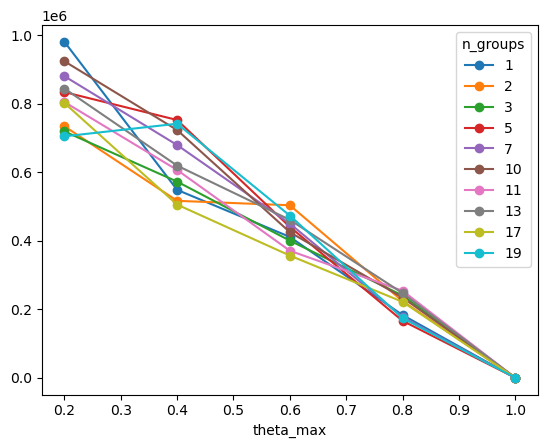

In [14]:
df_stats.pivot('theta_max', 'n_groups', 'n_interactions').plot(marker='o')

/var/folders/6z/lrdd38_n45q0wxx6fhjkfsk8vyg1nm/T/ipykernel_50171/4013209949.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_stats.pivot('n_groups', 'theta_max', 'n_interactions').plot()


<AxesSubplot: xlabel='n_groups'>

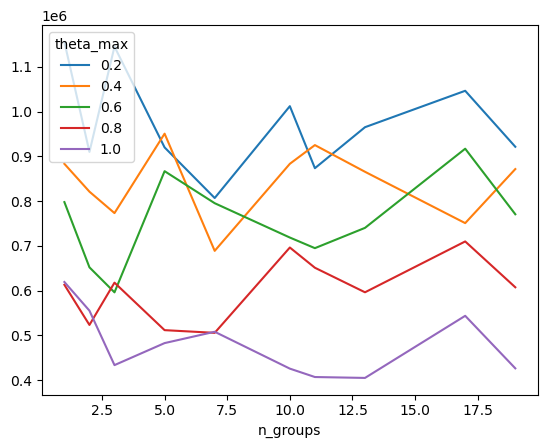

In [46]:
df_stats.pivot('n_groups', 'theta_max', 'n_interactions').plot()

/var/folders/6z/lrdd38_n45q0wxx6fhjkfsk8vyg1nm/T/ipykernel_78521/1227927392.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_stats.pivot('n_groups', 'theta_max', 'n_interactions').plot(marker='o')


<AxesSubplot: xlabel='n_groups'>

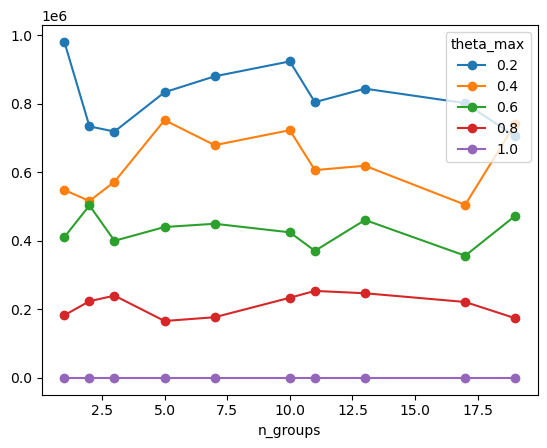

In [15]:
df_stats.pivot('n_groups', 'theta_max', 'n_interactions').plot(marker='o')

#### No mask, fixed

In [13]:
is_masking = False
is_fixed_response = True

In [14]:
df_stats = pd.read_csv('../data/ml-1m-response/{}/stats/rand_response_masking{}_fixed{}_train.csv'.format(ts, is_masking, is_fixed_response))

/var/folders/6z/lrdd38_n45q0wxx6fhjkfsk8vyg1nm/T/ipykernel_77730/493591887.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_stats.pivot('theta_max', 'n_groups', 'n_interactions').plot()


<AxesSubplot: xlabel='theta_max'>

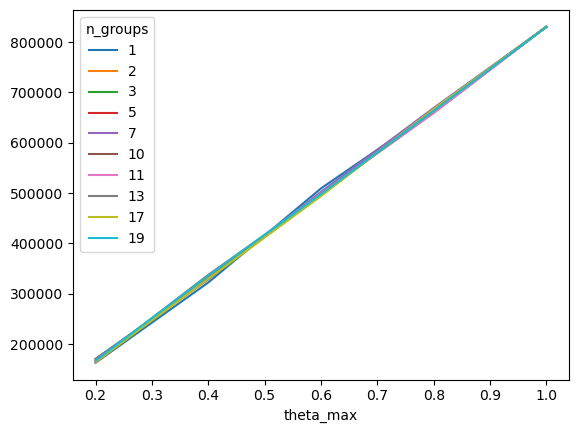

In [15]:
df_stats.pivot('theta_max', 'n_groups', 'n_interactions').plot()

/var/folders/6z/lrdd38_n45q0wxx6fhjkfsk8vyg1nm/T/ipykernel_77730/4013209949.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_stats.pivot('n_groups', 'theta_max', 'n_interactions').plot()


<AxesSubplot: xlabel='n_groups'>

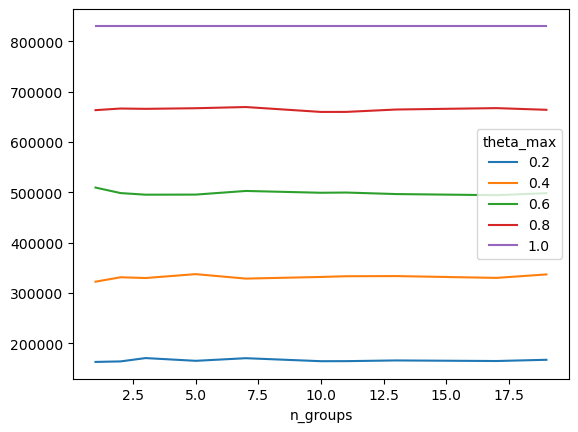

In [16]:
df_stats.pivot('n_groups', 'theta_max', 'n_interactions').plot()

In [13]:
ts = '231017'
df_stats_coinflip = pd.read_csv('../data/ml-1m-response/{}/stats/rand_response_masking{}_fixed{}_train.csv'.format(ts, is_masking, is_fixed_response))

/var/folders/6z/lrdd38_n45q0wxx6fhjkfsk8vyg1nm/T/ipykernel_23525/3134856671.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_stats_coinflip.pivot('theta_max', 'n_groups', 'n_interactions').plot()


<AxesSubplot: xlabel='theta_max'>

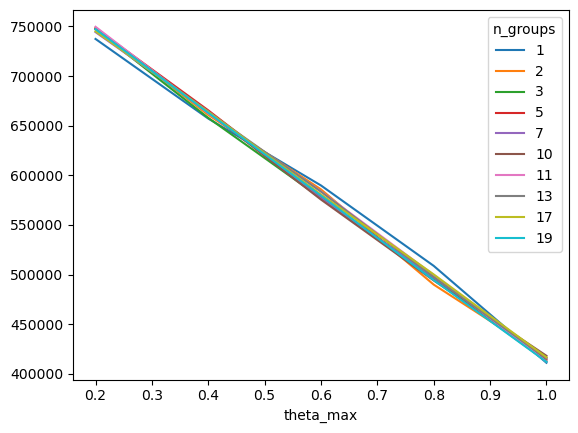

In [14]:
df_stats_coinflip.pivot('theta_max', 'n_groups', 'n_interactions').plot()

#### No mask, variable

In [30]:
is_masking = False
is_fixed_response = False

In [31]:
df_stats = pd.read_csv('../data/ml-1m-response/{}/stats/rand_response_masking{}_fixed{}_train.csv'.format(ts, is_masking, is_fixed_response))

/var/folders/6z/lrdd38_n45q0wxx6fhjkfsk8vyg1nm/T/ipykernel_42464/493591887.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_stats.pivot('theta_max', 'n_groups', 'n_interactions').plot()


<AxesSubplot: xlabel='theta_max'>

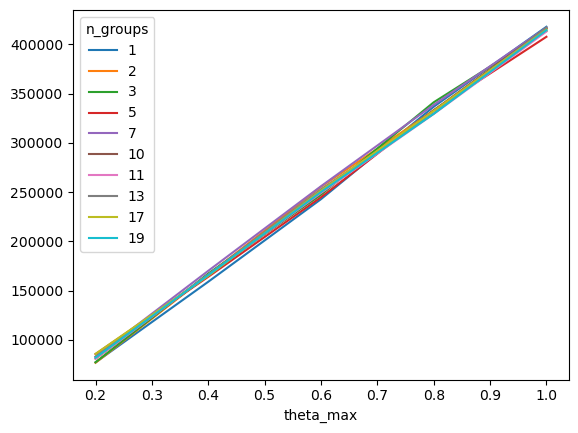

In [32]:
df_stats.pivot('theta_max', 'n_groups', 'n_interactions').plot()

/var/folders/6z/lrdd38_n45q0wxx6fhjkfsk8vyg1nm/T/ipykernel_42464/4013209949.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_stats.pivot('n_groups', 'theta_max', 'n_interactions').plot()


<AxesSubplot: xlabel='n_groups'>

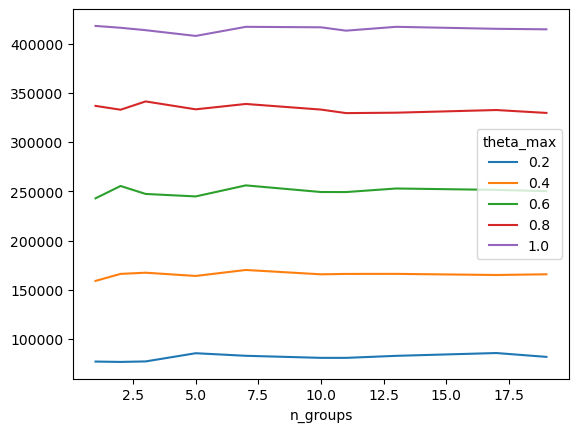

In [33]:
df_stats.pivot('n_groups', 'theta_max', 'n_interactions').plot()